In [62]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import scipy.integrate
import statsmodels.tsa.stattools


In [2]:
Q_0 = 342
eps = 0.62
delt = 5.67 * 1e-8
C = 1

In [49]:
T = 14000
n_steps_per_unit_time = 10
dt = 1/n_steps_per_unit_time
window_length = 700
n_windows = int(T/window_length) 

In [55]:
q0, qT = 0.7, 1.4  #vlt besser 0.8, 1.3
k0, kT = 1, 1
th0, thT = 1, 1

In [12]:
def q(t):
    return (1-t/T)*q0 + t/T * qT

In [37]:
def alpha(x):
    return 0.5 - 0.2*np.tanh((x-265)/10)

In [38]:
#here x is the temperature
def f(x,t):
    return ((1-alpha(x))*q(t)*Q_0 - eps*delt*x**4)/C

In [67]:
def f_prime(x,t):
    return (0.02*q(t)*(1/(np.cosh((x-265)/10))**2)-4*eps*delt*x**3)

In [56]:
#linear ramp for kappa
def kappa(t,k0,kT):
    return (1-t/T)*k0 + t/T*kT

#linear ramp for theta
def theta(t,th0,thT):
    return (1-t/T)*th0 + t/T*thT

In [45]:
def get_equilibria_paths():
    n = T + 1
    ts = np.linspace(0,T,n)
    upper = np.zeros(n)
    lower = np.zeros(n)
    unstable = np.zeros(n)

    for i in tqdm.trange(n):
        sol = scipy.integrate.solve_ivp(lambda t,x: f(x,ts[i]),(0.0,50),[280.0], method="BDF")
        upper[i] = sol.y[0,-1]
        sol = scipy.integrate.solve_ivp(lambda t,x: f(x,ts[i]),(0.0,50),[250.0], method="BDF")
        lower[i] = sol.y[0,-1]
        sol = scipy.integrate.solve_ivp(lambda t,x: -f(x,ts[i]),(0.0,50),[260.0], method="BDF")
        unstable[i] = sol.y[0,-1]
     
    unstable[(unstable < 250) | (unstable > 280)] = np.nan

    return ts,upper,lower,unstable

In [50]:
ts,upper,lower,unstable = get_equilibria_paths()

100%|██████████| 14001/14001 [06:56<00:00, 33.60it/s]


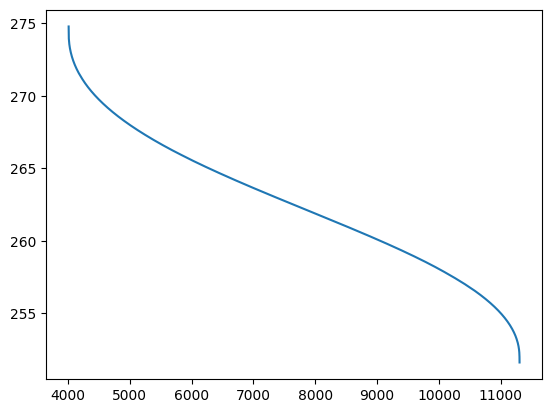

In [53]:
plt.plot(ts,unstable)

In [57]:
#simulate sample paths with euler method
n_steps = T*n_steps_per_unit_time
solve_ts = np.linspace(0,T,n_steps + 1)


xs = np.zeros(n_steps+1)
xs[0] = lower[0]
us = np.zeros(n_steps+1)

#simulate us
for i in tqdm.trange(n_steps):
    us[i+1] = np.exp(-theta(solve_ts[i],th0,thT)*dt)*us[i] + np.sqrt(1/(2*theta(solve_ts[i],th0,thT))*(1-np.exp(-2*theta(solve_ts[i],th0,thT)*dt)))*np.random.normal(0,1)

for i in tqdm.trange(n_steps):
    xs[i+1] = xs[i] + f(xs[i],solve_ts[i])*dt + kappa(solve_ts[i],k0,kT)*us[i]*dt

xs_filtered = xs[::n_steps_per_unit_time]
us_filtered = np.array([np.sum([us[i*n_steps_per_unit_time+j] for j in range(n_steps_per_unit_time)])*dt for i in range(T)])

  0%|          | 0/140000 [00:00<?, ?it/s]

100%|██████████| 140000/140000 [00:00<00:00, 197088.18it/s]


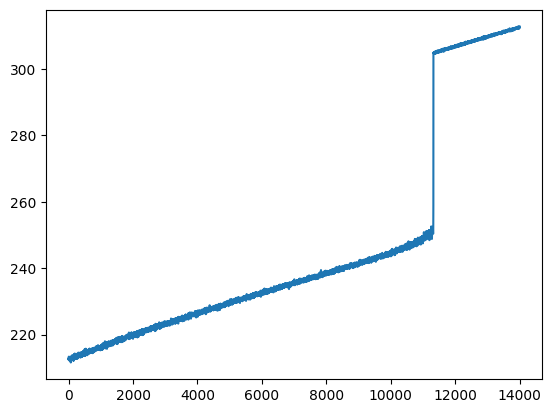

In [58]:
plt.plot(ts,xs_filtered)

In [59]:
#version with var and ar over several time units

def get_var(x):
    #get var of T-windows with length window length. Gives n_windows values
    var = np.full(n_windows,np.nan)
    for i in tqdm.trange(n_windows):
        var[i] = statsmodels.tsa.tsatools.detrend(x[i*window_length:(i+1)*window_length],order=2).var()
    return var


def get_ar(x):
#x should have size T*steps_per_unit_time + 1
    ar = np.full(n_windows,np.nan)
    for i in tqdm.trange(n_windows):
        ar[i] = statsmodels.tsa.stattools.acf(statsmodels.tsa.tsatools.detrend(x[i*window_length:(i+1)*window_length],order=2))[1]
    return ar


In [60]:
#ls version without convolution

def get_ls_k(x,noise):


    def fitfunction(f,ls):
        return np.log(1/(f**2  + ls**2))
    

    n_windows = int(T/window_length) 
    ls = np.full(n_windows,np.nan)



    for i in tqdm.trange(n_windows):
        frequencies = 2*np.pi*(1/window_length)*np.arange(1,window_length/2)                                                #here window_length should be even

        xs_window_detrend = statsmodels.tsa.tsatools.detrend(x[i*window_length:(i+1)*window_length],order=2)
        noise_window = noise[i*window_length:(i+1)*window_length]
        kappa_window = kappa(np.arange(i*window_length,(i+1)*window_length),k0,kT)                                                                               
        
        estim_psd_xs_wn = np.array([np.abs(1/np.sqrt(window_length)*(np.exp(-1j*frequencies[j]*np.arange(0,window_length)) @ xs_window_detrend))**2 for j in range(int(window_length/2) - 1)])
        estim_psd_xi_wn = np.array([np.abs(1/np.sqrt(window_length)*(np.exp(-1j*frequencies[n]*np.arange(0,window_length)) @ (noise_window*kappa_window)))**2 for n in range(int(window_length/2) - 1)])

        popt = scipy.optimize.curve_fit(fitfunction,
                                                frequencies, 
                                                np.log(estim_psd_xs_wn/estim_psd_xi_wn),
                                                p0=[1.0],
                                                bounds=(0.0, np.inf))[0]
        ls[i] = popt[0]

        
    return ls


In [63]:
var_xs = get_var(xs_filtered)
ar_xs = get_ar(xs_filtered)
ls_xs = get_ls_k(xs_filtered,us_filtered)

100%|██████████| 20/20 [00:00<00:00, 25.71it/s]


Text(0.5, 0, 'Q/Q0')

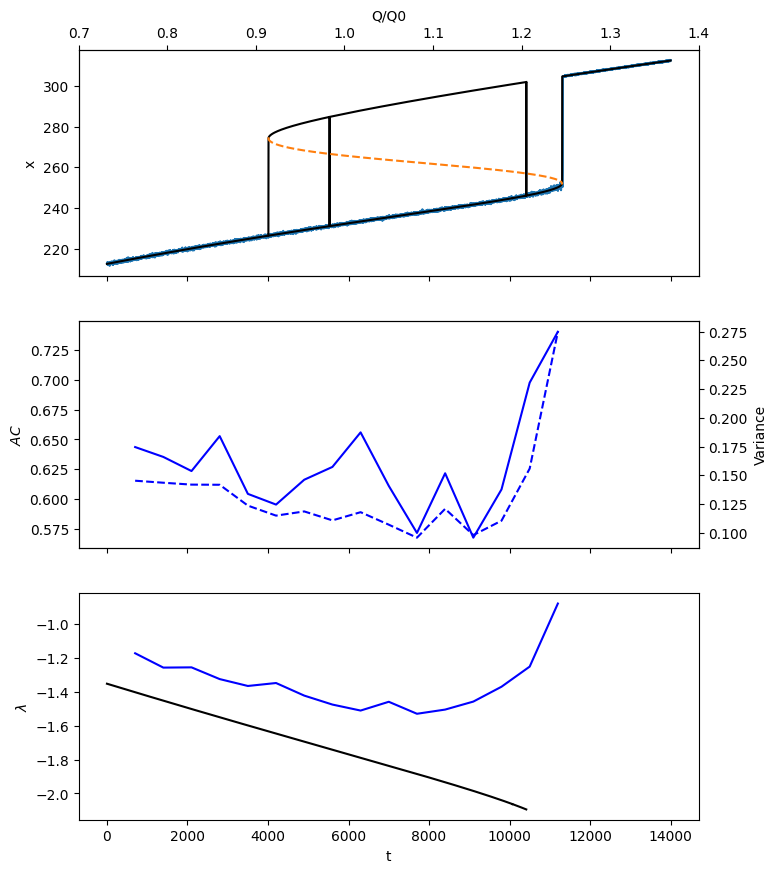

In [68]:
#why is lambda estimation so far from true lambda?, how to choose fs in ls method?  

tipp_lower = np.argmin(lower<252)       #what is the exact value?
tipp_upper = np.argmin(upper<272)


tipp_xs = np.argmin(xs_filtered<252) 

fig,axs = plt.subplots(nrows=3,ncols=1,sharex=True,figsize=(8,10)) 

axs[0].plot(ts,xs_filtered)


axs[0].plot(ts[:tipp_lower],upper[:tipp_lower],color = "black")
axs[0].plot(ts[tipp_upper:],lower[tipp_upper:],color = "black")
# axs[0].plot(ts[~np.isnan(unstable)],unstable[~np.isnan(unstable)],linestyle = "--")
axs[0].plot(ts,unstable,linestyle = "--")


axs[1].plot(ts[window_length:tipp_xs:window_length],ar_xs[:int(tipp_xs/window_length)],color="blue")                               
ax1_var = axs[1].twinx()
ax1_var.plot(ts[window_length:tipp_xs:window_length],var_xs[:int(tipp_xs/window_length)],color="blue",linestyle="--")


axs[0].set_ylabel("x")
axs[1].set_ylabel(r"$AC$")
ax1_var.set_ylabel(r"Variance")



axs[2].set_xlabel("t")    
axs[2].plot(ts[window_length:tipp_xs:window_length],-ls_xs[:int(tipp_xs/window_length)],color="blue")
axs[2].plot(ts[:tipp_lower],f_prime(lower[:tipp_lower],ts[:tipp_lower]),color="black")
axs[2].set_ylabel(r"$\lambda$")


ax_0 = axs[0].twiny()
ax_0.set_xlim(0.7,1.4)
ax_0.set_xlabel("Q/Q0")